# Tutorial For Tensorflow 1.14(stable) (1.x) CISC/CMPE 452 / CISC 874 / COGS 400

This tutorial is split into two parts. The first part will go over a simple linear function optimization using tensorflow. The second part will go over using tensorflow 1.14 to solve the MNIST DIGIT classification challenge and has a useful example of how to load the data for MNIST into your python environment using tensorflow/keras.

In Tensorflow 1.14, the majority of the environment is in 'Graph Execution'. This means that, unlike typical python, it is a define then run environment. You can enable Eager Execution in order to be able to quickly debug, but rest assured that Graph Execution is exceptionally fast and optimization is easy. 

Finally, I recommend always having the API for Tensorflow 1.14(stable) up while coding, so here it is: [TF-1.14(stable)](https://www.tensorflow.org/api_docs/python/tf)

In [0]:
!pip install tensorflow-gpu==1.14.0 numpy matplotlib tqdm --no-cache-dir

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
print(tf.__version__)

1.14.0


# Linear Function Optimization

This section goes over creating a small dataset of a noisy linear function and using tensorflow 1.14 to solve it.

In [0]:
X = np.random.normal(0.0,0.2,1000)
noise = np.random.normal(0.0,0.45,1000)
X.shape

(1000,)

In [0]:
true_W = np.random.rand()*100
true_B = np.random.rand()*100

Y = true_W*X + true_B + noise
print("True_W: ",true_W)
print("True_B: ",true_B)
print("Shape: ",Y.shape)

True_W:  47.3411455433012
True_B:  63.38494315102007
Shape:  (1000,)


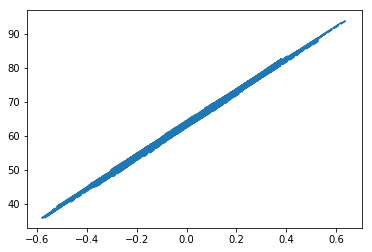

In [0]:
plt.plot(X[:],Y[:],'--')

In [0]:
W = tf.Variable(1.0)
B = tf.Variable(0.0)

In [0]:
data_X = tf.data.Dataset.from_tensor_slices(X.astype(np.float32))
data_Y = tf.data.Dataset.from_tensor_slices(Y.astype(np.float32))
dataset = tf.data.Dataset.zip((data_X,data_Y)).batch(32)
print(data_X,data_Y)
print(dataset)

<DatasetV1Adapter shapes: (), types: tf.float32> <DatasetV1Adapter shapes: (), types: tf.float32>
<DatasetV1Adapter shapes: ((?,), (?,)), types: (tf.float32, tf.float32)>


In [0]:
iterator = dataset.make_initializable_iterator()
X_t, Y_t = iterator.get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


In [0]:
pred_T = X_t*W + B
loss_T = tf.reduce_mean(tf.square(Y_t - pred_T))


In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
global_step = tf.train.get_global_step()

grads = optimizer.compute_gradients(loss_T)
train_op = optimizer.apply_gradients(grads,global_step=global_step)


In [0]:
print(pred_T)
print(loss_T)
print(train_op)

Tensor("add:0", shape=(?,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)
name: "Adam"
op: "NoOp"
input: "^Adam/update_Variable/ApplyAdam"
input: "^Adam/update_Variable_1/ApplyAdam"
input: "^Adam/Assign"
input: "^Adam/Assign_1"



In [0]:
sess = tf.Session()

In [0]:
sess.run(iterator.initializer)
sess.run(tf.global_variables_initializer())

In [0]:
pbar = tqdm(range(100))
for epoch in pbar:
  sess.run(iterator.initializer)
  while True:
    try:
      _, loss_val, W_val, B_val = sess.run([train_op,loss_T, W, B])
    except:
      break
  pbar.set_description('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
          (epoch, W_val, B_val, loss_val))

Epoch 99: W=47.55 b=63.41, loss=0.13183: 100%|██████████| 100/100 [00:04<00:00, 24.55it/s]


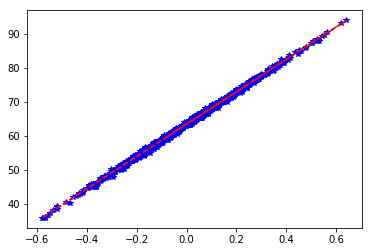

In [0]:
plt.plot(X,Y,'b*')
inp_dict = tf.placeholder(tf.float32)
o = W*inp_dict + B
out = sess.run(o,feed_dict={inp_dict:X})
plt.plot(X,out,'r--')

In [0]:
sess.close()
tf.reset_default_graph()

# MNIST Challenge

This section uses tf.keras.datasets to load the MNIST dataset and TF-1.14 to optimize a simple neural network to solve the digit classification challenge. This is a quick and easy way to create custom models and custom training loops. 

In [0]:
(train_x, train_y),(test_x,test_y) = tf.keras.datasets.mnist.load_data()
num_classes = 10
print(train_x.shape,train_y.shape,test_x.shape,test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [0]:
inp_t = tf.placeholder(tf.float32,[None, 28,28,1])
target_t = tf.placeholder(tf.int32,[None,1])
target_logits = tf.squeeze(tf.one_hot(target_t,num_classes),axis=1)
print(inp_t,target_logits)

Tensor("Placeholder:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("Squeeze:0", shape=(?, 10), dtype=float32)


In [0]:

x = tf.layers.conv2d(inp_t,32,[3,3],padding='same')
x = tf.layers.batch_normalization(x)
x = tf.layers.max_pooling2d(x,2,2)
f = tf.layers.flatten(x)
logits_t = tf.layers.dense(f,10)
pred_t = tf.argmax(tf.nn.softmax(logits_t,axis=-1),axis=-1)
loss_t = tf.losses.softmax_cross_entropy(target_logits,logits_t)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
global_step = tf.train.get_global_step()

gradients, variables = zip(*optimizer.compute_gradients(loss_t))
gradients = [ None if gradient is None else tf.clip_by_value(gradient, -1,1)
    for gradient in gradients]
gvs = zip(gradients,variables)
train_op = optimizer.apply_gradients(gvs,global_step=global_step)

acc_t, acc_update = tf.metrics.accuracy(target_t,pred_t)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
train_x = np.expand_dims(train_x,-1)/255.
train_y = np.expand_dims(train_y,-1)
test_x = np.expand_dims(test_x,-1)/255.
test_y = np.expand_dims(test_y,-1)

In [0]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((60000, 28, 28, 1), (60000, 1), (10000, 28, 28, 1), (10000, 1))

In [0]:
bs = 32
num_epochs = 5
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [0]:
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    losses = []
    accs = []
    for i in range(0,train_x.shape[0],bs):
        _, loss, _, acc = sess.run([train_op, loss_t, acc_update, acc_t],
                                   feed_dict={
                                       inp_t: train_x[:bs,...],
                                       target_t: train_y[:bs,...] 
                                   })
        losses.append(loss)
        accs.append(acc)
    pbar.set_description('Epoch %2d: loss=%2.5f, acc=%2.5f' %
          (epoch,sum(losses)/len(losses),sum(accs)/len(accs)))
sess.close()

Epoch  4: loss=0.00000, acc=0.99943: 100%|██████████| 5/5 [00:27<00:00,  5.59s/it]


In [0]:
tf.reset_default_graph()
data_X = tf.data.Dataset.from_tensor_slices(train_x.astype(np.float32))
data_Y = tf.data.Dataset.from_tensor_slices(train_y.astype(np.int32))
dataset = tf.data.Dataset.zip((data_X,data_Y)).shuffle(buffer_size = 1000).batch(bs)
print(dataset)

<DatasetV1Adapter shapes: ((?, 28, 28, 1), (?, 1)), types: (tf.float32, tf.int32)>


In [0]:
iterator = dataset.make_initializable_iterator()
X_t, Y_t = iterator.get_next()
Y_logits_t = tf.squeeze(tf.one_hot(Y_t,num_classes),axis=1)
print(X_t,Y_t,Y_logits_t)

Tensor("IteratorGetNext:0", shape=(?, 28, 28, 1), dtype=float32) Tensor("IteratorGetNext:1", shape=(?, 1), dtype=int32) Tensor("Squeeze:0", shape=(?, 10), dtype=float32)


In [0]:
x = tf.layers.conv2d(X_t,32,[3,3],padding='same')
x = tf.layers.batch_normalization(x)
x = tf.layers.max_pooling2d(x,2,2)
f = tf.layers.flatten(x)
logits_t = tf.layers.dense(f,10)
pred_t = tf.argmax(tf.nn.softmax(logits_t,axis=-1),axis=-1)
loss_t = tf.losses.softmax_cross_entropy(Y_logits_t,logits_t)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
global_step = tf.train.get_global_step()

gradients, variables = zip(*optimizer.compute_gradients(loss_t))
gradients = [ None if gradient is None else tf.clip_by_value(gradient, -1,1)
    for gradient in gradients]
gvs = zip(gradients,variables)
train_op = optimizer.apply_gradients(gvs,global_step=global_step)

acc_t, acc_update = tf.metrics.accuracy(Y_t,pred_t)

In [0]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())


In [0]:
pbar = tqdm(range(num_epochs))
for epoch in pbar:
    sess.run(iterator.initializer)
    losses = []
    accs = []
    while True:
        try:
            _, loss, _, acc = sess.run([train_op, loss_t, acc_update, acc_t])
            losses.append(loss)
            accs.append(acc)
        except tf.errors.OutOfRangeError:
            break
    pbar.set_description('Epoch %2d: loss=%2.5f, acc=%2.5f' %
          (epoch,sum(losses)/len(losses),sum(accs)/len(accs)))
    


Epoch  4: loss=0.05474, acc=0.96597: 100%|██████████| 5/5 [00:24<00:00,  5.02s/it]


In [0]:
sess.close()